# Importing Needed Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import xgboost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold


## Loading And Exploring Data

In [2]:
# Loading dataset
df = pd.read_csv('weatherAUS.csv')

In [3]:
#Displaying the first five rows
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [4]:
# Getting information regarding the number of rows and columns in the dataset
# Results indicate that the rows are 145460, and 23 columns

df.shape

(145460, 23)

In [5]:
# Getting an idea about the variables. Displaying all variables and data type. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
# This is to find out the number of missing values for each variable. 
# It is observed that apart from Date and Location, all the other variables have missing values.

df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [7]:
# General stats of categoric variables
df.describe(include=['object'])

Date  Location WindGustDir WindDir9am WindDir3pm RainToday  \
count       145460    145460      135134     134894     141232    142199   
unique        3436        49          16         16         16         2   
top     2013-05-23  Canberra           W          N         SE        No   
freq            49      3436        9915      11758      10838    110319   

       RainTomorrow  
count        142193  
unique            2  
top              No  
freq         110316

## Deleting variables with very high missing values to avoid bias:
### 1. The affected variables are: Evaporation, Sunshine, Cloud9am, Cloud3pm have  a lot of missing data. The variable Date will also be deleted since it is not necessary rainfall prediction.
### 2. The missing values for the Dependent variable, RainTomorrow are 3267 (just about 2%) will also be deleted.

In [8]:
# Deleting columns with a lot of missing values (Evaporation, Sunshine, Cloud9am, Cloud3pm) and 
# the Date column is it will also not be useful.
# A new dataframe called mod_df is created.
mod_df=df.drop(["Evaporation","Sunshine","Cloud9am","Cloud3pm","Date"], axis = 1)

# Displaying the first five rows to confirm that the changes have taken effect.
mod_df.head()

Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed WindDir9am  \
0   Albury     13.4     22.9       0.6           W           44.0          W   
1   Albury      7.4     25.1       0.0         WNW           44.0        NNW   
2   Albury     12.9     25.7       0.0         WSW           46.0          W   
3   Albury      9.2     28.0       0.0          NE           24.0         SE   
4   Albury     17.5     32.3       1.0           W           41.0        ENE   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        WNW          20.0          24.0         71.0         22.0   
1        WSW           4.0          22.0         44.0         25.0   
2        WSW          19.0          26.0         38.0         30.0   
3          E          11.0           9.0         45.0         16.0   
4         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm RainToday RainTomorrow  
0       1007.7       1007.1     16.9     21.8        No           No  
1       1010.6       1007.8     17.2     24.3        No           No  
2       1007.6       1008.7     21.0     23.2        No           No  
3       1017.6       1012.8     18.1     26.5        No           No  
4       1010.8       1006.0     17.8     29.7        No           No

In [9]:
# Deleting missing rows in the variable RainTomorrow 
mod_df = mod_df.dropna(how='any',subset=['RainTomorrow'])

#Confirming that there are no missing values in RainTomorrow
mod_df.isnull().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [10]:
# Frequency distribution of category of rainfall 
RainTomorrow_count= mod_df['RainTomorrow'].value_counts()
print(RainTomorrow_count)

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64


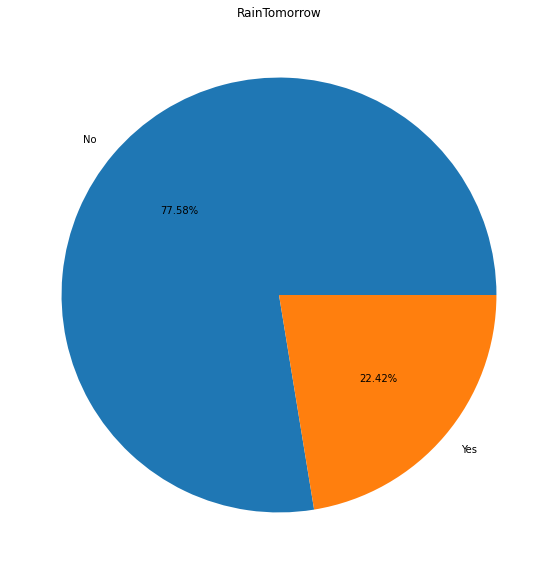

In [11]:
# A pie plot of the Dependent variable indicating how unbalanced it is.
plt.figure(figsize=(20,10))
plt.title('RainTomorrow')
plt.pie(RainTomorrow_count, labels=RainTomorrow_count.index, autopct='%1.2f%%');

This indicates that the Distribution for RainTomorrow is highly unbalanced

In [12]:
# Converting the target from binary/categoric into binary/numeric

mod_df['RainTomorrow'] = mod_df['RainTomorrow'].map({'Yes':1, 'No':0})
mod_df.head()


Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed WindDir9am  \
0   Albury     13.4     22.9       0.6           W           44.0          W   
1   Albury      7.4     25.1       0.0         WNW           44.0        NNW   
2   Albury     12.9     25.7       0.0         WSW           46.0          W   
3   Albury      9.2     28.0       0.0          NE           24.0         SE   
4   Albury     17.5     32.3       1.0           W           41.0        ENE   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0        WNW          20.0          24.0         71.0         22.0   
1        WSW           4.0          22.0         44.0         25.0   
2        WSW          19.0          26.0         38.0         30.0   
3          E          11.0           9.0         45.0         16.0   
4         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm RainToday  RainTomorrow  
0       1007.7       1007.1     16.9     21.8        No             0  
1       1010.6       1007.8     17.2     24.3        No             0  
2       1007.6       1008.7     21.0     23.2        No             0  
3       1017.6       1012.8     18.1     26.5        No             0  
4       1010.8       1006.0     17.8     29.7        No             0

## Dealing with missing values in numeric variables:
### The following approach will be applied:
### 1. Where the variable is skewed (as in Rainfall, WindGustSpeed, WindSpeed9am, WindSpeed3am, and Humidity9am) the Median would be used to replace all missing values.
### 2. Where the variable approaches normality or bell-shaped (as in MinTemp, MaxTemp, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, and Temp3pm) the Mean would be used to replace all missing values.


In [13]:
# Basic statistics on all numberic variables
mod_df.describe()

MinTemp        MaxTemp       Rainfall  WindGustSpeed  \
count  141556.000000  141871.000000  140787.000000  132923.000000   
mean       12.186400      23.226784       2.349974      39.984292   
std         6.403283       7.117618       8.465173      13.588801   
min        -8.500000      -4.800000       0.000000       6.000000   
25%         7.600000      17.900000       0.000000      31.000000   
50%        12.000000      22.600000       0.000000      39.000000   
75%        16.800000      28.200000       0.800000      48.000000   
max        33.900000      48.100000     371.000000     135.000000   

        WindSpeed9am   WindSpeed3pm    Humidity9am    Humidity3pm  \
count  140845.000000  139563.000000  140419.000000  138583.000000   
mean       14.001988      18.637576      68.843810      51.482606   
std         8.893337       8.803345      19.051293      20.797772   
min         0.000000       0.000000       0.000000       0.000000   
25%         7.000000      13.000000      57.000000      37.000000   
50%        13.000000      19.000000      70.000000      52.000000   
75%        19.000000      24.000000      83.000000      66.000000   
max       130.000000      87.000000     100.000000     100.000000   

         Pressure9am    Pressure3pm        Temp9am        Temp3pm  \
count  128179.000000  128212.000000  141289.000000  139467.000000   
mean     1017.653758    1015.258204      16.987509      21.687235   
std         7.105476       7.036677       6.492838       6.937594   
min       980.500000     977.100000      -7.200000      -5.400000   
25%      1012.900000    1010.400000      12.300000      16.600000   
50%      1017.600000    1015.200000      16.700000      21.100000   
75%      1022.400000    1020.000000      21.600000      26.400000   
max      1041.000000    1039.600000      40.200000      46.700000   

        RainTomorrow  
count  142193.000000  
mean        0.224181  
std         0.417043  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

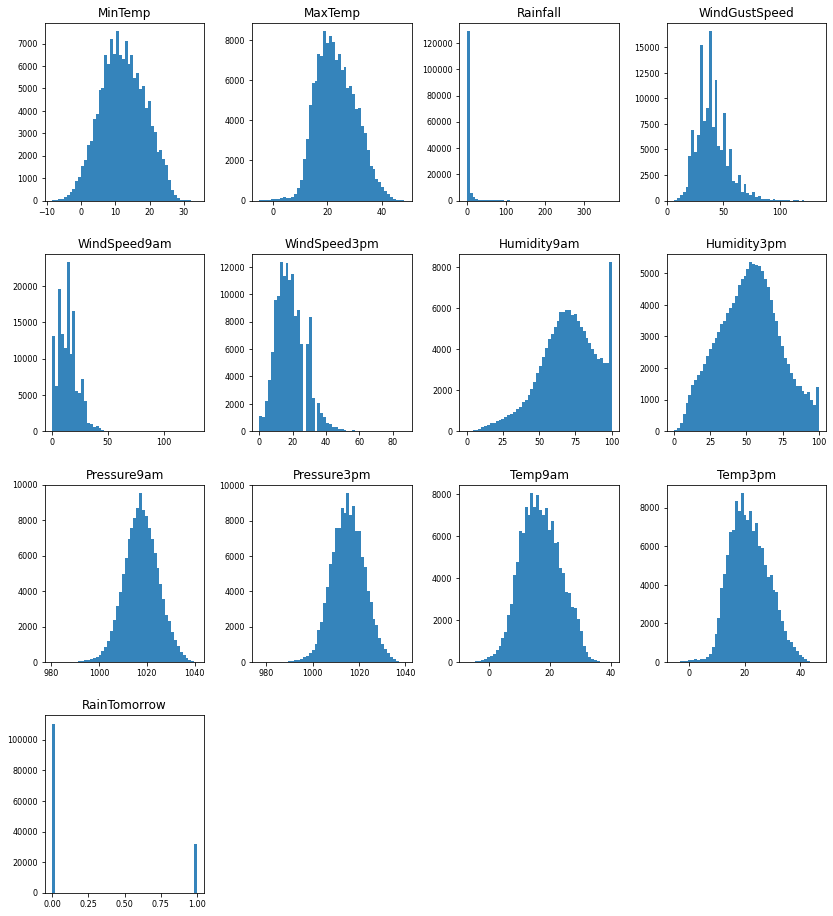

In [14]:
# Graphic visualization of the numeric distribution to determine which variables are skewed and which ones approach normality
mod_df.hist(figsize=(14, 16), bins=50, xlabelsize=8, ylabelsize=8, alpha=0.9, grid=False)
plt.show()

In [15]:
# Replacing missing values for Rainfall with the median value
mod_df['Rainfall'].fillna(mod_df['Rainfall'].median(),inplace=True)

# Replacing missing values for WindGustSpeed with the median value
mod_df['WindGustSpeed'].fillna(mod_df['WindGustSpeed'].median(),inplace=True)

# Replacing missing values for WindSpeed9am with the median value
mod_df['WindSpeed9am'].fillna(mod_df['WindSpeed9am'].median(),inplace=True)

# Replacing missing values for WindSpeed3pm with the median value
mod_df['WindSpeed3pm'].fillna(mod_df['WindSpeed3pm'].median(),inplace=True)

# Replacing missing values for Humidity9am with the median value
mod_df['Humidity9am'].fillna(mod_df['Humidity9am'].median(),inplace=True)

In [16]:
# Checking the missing values once again to ensure that the median replacements have taken effect
mod_df.isna().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall             0
WindGustDir       9330
WindGustSpeed        0
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [17]:
# Replacing missing values for MinTemp with the mean value
mod_df['MinTemp'].fillna(mod_df['MinTemp'].mean(),inplace=True)

# Replacing missing values for MaxTemp with the mean value
mod_df['MaxTemp'].fillna(mod_df['MaxTemp'].mean(),inplace=True)

# Replacing missing values for Humidity3pm with the mean value
mod_df['Humidity3pm'].fillna(mod_df['Humidity3pm'].mean(),inplace=True)

# Replacing missing values for Pressure9am with the mean value
mod_df['Pressure9am'].fillna(mod_df['Pressure9am'].mean(),inplace=True)

# Replacing missing values for Pressure3pm with the mean value
mod_df['Pressure3pm'].fillna(mod_df['Pressure3pm'].mean(),inplace=True)

# Replacing missing values for Temp9am with the mean value
mod_df['Temp9am'].fillna(mod_df['Temp9am'].mean(),inplace=True)

# Replacing missing values for Temp3pm with the mean value
mod_df['Temp3pm'].fillna(mod_df['Temp3pm'].mean(),inplace=True)


In [18]:
# Checking the missing values once again to ensure that the mean replacements have taken effect
mod_df.isna().sum()

Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
WindGustDir       9330
WindGustSpeed        0
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Temp9am              0
Temp3pm              0
RainToday         1406
RainTomorrow         0
dtype: int64

## Dealing with missing values in categorical variables:


In [19]:
# Analyzing the how missing values in the variable WindGustDir against dependent variable Rainfall.

mod_df.groupby(mod_df['WindGustDir'].isnull())['RainTomorrow'].mean()

WindGustDir
False    0.221356
True     0.264416
Name: RainTomorrow, dtype: float64

In [20]:
# Analyzing the how missing values in the variable WindDir9am against dependent variable Rainfall.

mod_df.groupby(mod_df['WindDir9am'].isnull())['RainTomorrow'].mean()

WindDir9am
False    0.226630
True     0.191851
Name: RainTomorrow, dtype: float64

In [21]:
# Analyzing the how missing values in the variable WindDir3pm against dependent variable Rainfall.

mod_df.groupby(mod_df['WindDir3pm'].isnull())['RainTomorrow'].mean()

WindDir3pm
False    0.222693
True     0.278719
Name: RainTomorrow, dtype: float64

In [22]:
# Analyzing the how missing values in the variable WindDir3pm against dependent variable Rainfall.

mod_df.groupby(mod_df['RainToday'].isnull())['RainTomorrow'].mean()

RainToday
False    0.221618
True     0.480797
Name: RainTomorrow, dtype: float64

#### 1. A general observation from above is that the missing values in categorical variables are randomly distributed. However, chances of rainfall are higher in situations where there are missing values for the variable RainToday.
#### 2. The value with the highest frequent will be used to replace the missing values in each instant.

In [23]:
#Replacing missing values for WindGustDir with the most frequent value
mod_df['WindGustDir'].fillna(mod_df['WindGustDir'].value_counts().index[0],inplace=True)

In [24]:
#Replacing missing values for WindDir9am with the most frequent value
mod_df['WindDir9am'].fillna(mod_df['WindDir9am'].value_counts().index[0],inplace=True)

In [25]:
#Replacing missing values for WindDir3pm with the most frequent value
mod_df['WindDir3pm'].fillna(mod_df['WindDir3pm'].value_counts().index[0],inplace=True)

In [26]:
#Replacing missing values for RainToday with the most frequent value
mod_df['RainToday'].fillna(mod_df['RainToday'].value_counts().index[0],inplace=True)

In [27]:
# Checking whether the dataset is clean and that there are no missing values.
mod_df.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

### Encoding: Transforming all categorical variables to numeric variables for effecient machine learning

In [28]:
mod_df['Location'] = le.fit_transform(mod_df['Location'])
mod_df['WindGustDir'] = le.fit_transform(mod_df['WindGustDir'])
mod_df['WindDir9am'] = le.fit_transform(mod_df['WindDir9am'])
mod_df['WindDir3pm'] = le.fit_transform(mod_df['WindDir3pm'])
mod_df['RainToday'] = le.fit_transform(mod_df['RainToday'])
# mod_df['RainTomorrow'] = le.fit_transform(mod_df['RainTomorrow'])

In [29]:
# Diplaying the first five rows of the data to confirm that the conversion has taken place.
mod_df.head()

Location  MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  \
0         2     13.4     22.9       0.6           13           44.0   
1         2      7.4     25.1       0.0           14           44.0   
2         2     12.9     25.7       0.0           15           46.0   
3         2      9.2     28.0       0.0            4           24.0   
4         2     17.5     32.3       1.0           13           41.0   

   WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  \
0          13          14          20.0          24.0         71.0   
1           6          15           4.0          22.0         44.0   
2          13          15          19.0          26.0         38.0   
3           9           0          11.0           9.0         45.0   
4           1           7           7.0          20.0         82.0   

   Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  \
0         22.0       1007.7       1007.1     16.9     21.8          0   
1         25.0       1010.6       1007.8     17.2     24.3          0   
2         30.0       1007.6       1008.7     21.0     23.2          0   
3         16.0       1017.6       1012.8     18.1     26.5          0   
4         33.0       1010.8       1006.0     17.8     29.7          0   

   RainTomorrow  
0             0  
1             0  
2             0  
3             0  
4             0

### Visualizations.

<AxesSubplot:>

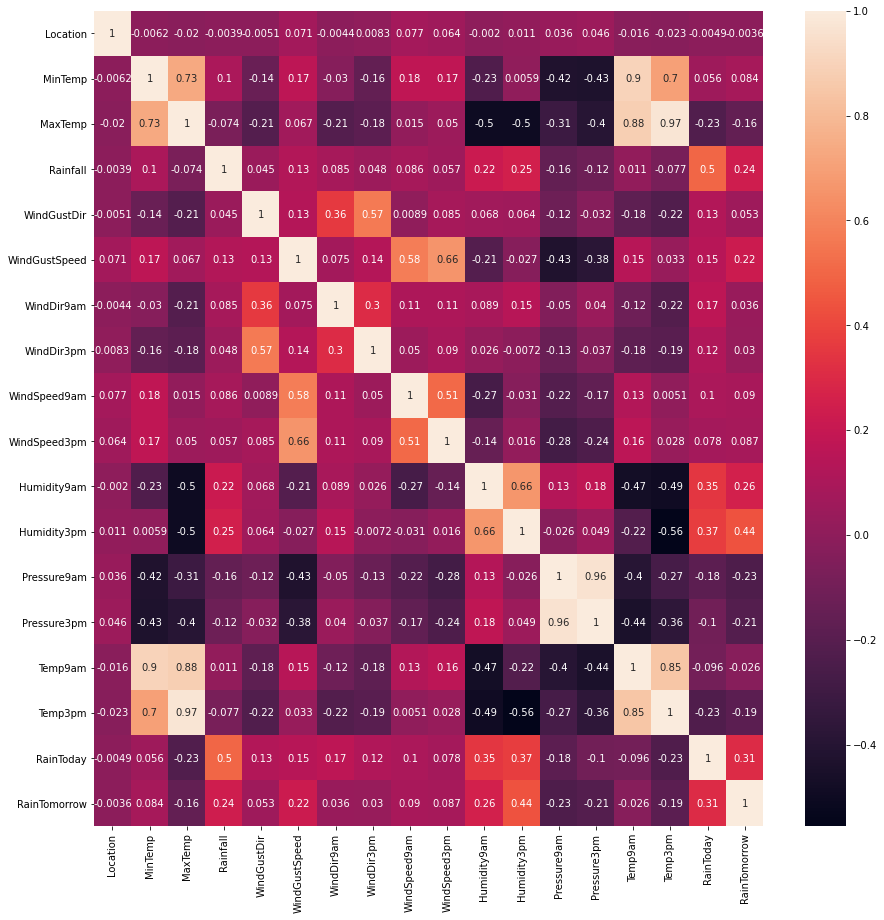

In [30]:
# Correlation Matrix
corr = mod_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels=corr.columns, annot=True)


It is observed from the correlation matrix that RainTomorrow has weak correlation with all the other variables except Humidity3pm where the correlation is weak.

<AxesSubplot:xlabel='Humidity9am', ylabel='MinTemp'>

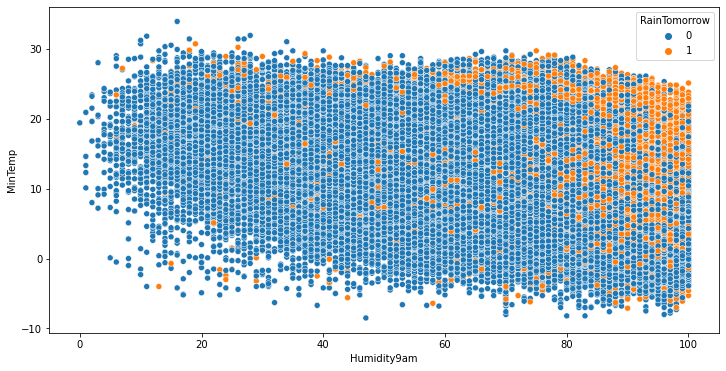

In [31]:
# A scatter plot of Humdity at 9am (Humidity9am) and Minimum Temperature (MinTemp) with respect to possibility of rainfall
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mod_df, x=mod_df['Humidity9am'], y=mod_df['MinTemp'], hue='RainTomorrow')

It is observed that there is a higher probability of rainfall when humidity increases and temperature also increases.

<AxesSubplot:xlabel='Humidity3pm', ylabel='Pressure3pm'>

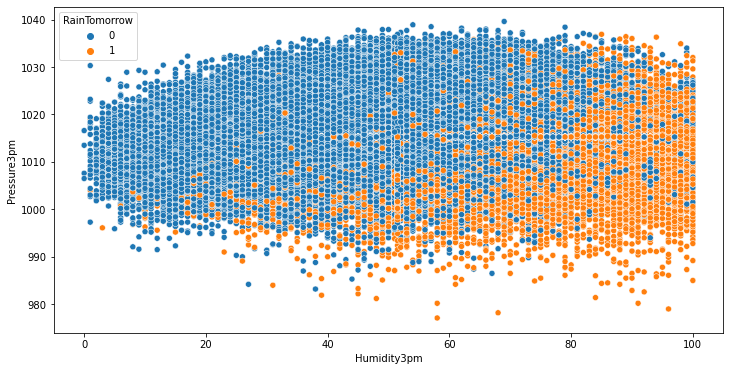

In [32]:
# A scatter plot of Humdity at 3pm (Humidity3pm) and Pressure recorded at 3pm (Pressure3pm) with respect to possibility of rainfall
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mod_df, x=mod_df['Humidity3pm'], y=mod_df['Pressure3pm'], hue='RainTomorrow')

It can be deduced that at higher humidity, between 60 and 100 units, and with pressure between 990 and 1020 units, the possibility of rainfall the next day is high.

<AxesSubplot:xlabel='MaxTemp', ylabel='Pressure3pm'>

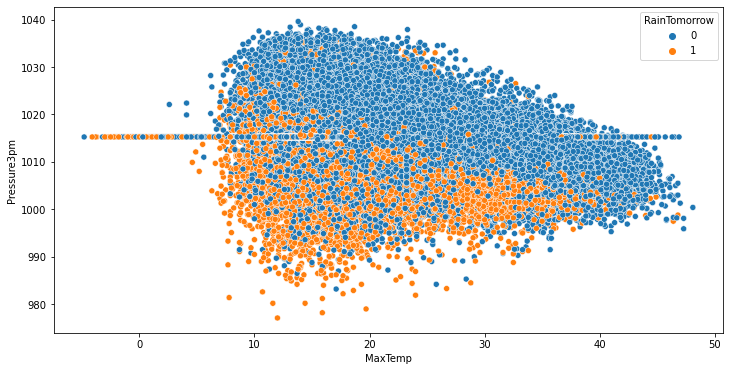

In [33]:
# A scatter plot of Maximum Temperature (MaxTemp) and Pressure recorded at 3pm (Pressure3pm) with respect to possibility of rainfall
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mod_df, x=mod_df['MaxTemp'], y=mod_df['Pressure3pm'], hue='RainTomorrow')

It can be deduced that there is a greater chance for rainfall when the maximum temperature is between 10 and 35 units, and the pressure is not more than 1015 units.

### Separating the dataset into dependent variable, y and independent variable x.

In [34]:
x = mod_df.drop(['RainTomorrow'], axis = 1)
y = mod_df['RainTomorrow']

### Separating the data into 80% Training Dataset and 20% Test set.

In [35]:
# Splitting the data into training set and test set.
# 80% would be used for training and 20% Testing

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=0)

### Hyperparameter Tuning Using RandomizedSearchCV

In [36]:
lr = LogisticRegression( max_iter=10000)


In [37]:

# Parameter options list

params = [    
    {
    'penalty' : ['l2', 'none'],
    'C' :   [0.001, 0.01, 0.1, 1, 10],
    'solver' : ['lbfgs','newton-cg'],
    
    }
]



cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

RandomizedSearchCV was used because it is faster than GridSearchCV

In [38]:
# classifier=xgboost.XGBClassifier(eval_metric='mlogloss')

In [39]:
random_search=RandomizedSearchCV(lr,param_distributions=params, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv)

In [40]:
random_search.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=LogisticRegression(max_iter=10000), n_iter=20,
                   n_jobs=-1,
                   param_distributions=[{'C': [0.001, 0.01, 0.1, 1, 10],
                                         'penalty': ['l2', 'none'],
                                         'solver': ['lbfgs', 'newton-cg']}],
                   scoring='accuracy')

In [41]:
# summarize result
print('Best Score: %s' % random_search.best_score_)
print('Best Hyperparameters: %s' % random_search.best_params_)

Best Score: 0.8386400959799694
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}


In [42]:
# This ignores the best Hyperparameters above but with a max_iter value of 10000
mod_lr = LogisticRegression(max_iter=10000)
mod_lr.fit(x_train, y_train)
predictions = mod_lr.predict(x_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[20947  1120]
 [ 3425  2947]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22067
           1       0.72      0.46      0.56      6372

    accuracy                           0.84     28439
   macro avg       0.79      0.71      0.73     28439
weighted avg       0.83      0.84      0.83     28439

0.8401842540173705


This shows that it was not impossible to achieve convergence with the suggested hyperparameters. However, by using all default parameters and only setting max_iter = 10000 convergence was obtained.